# **Initialization**

In [137]:
import pandas as pd
import re
import spacy
from collections import Counter
from textblob import TextBlob
from google.colab import drive

#### Mount google drive where the csv files are stored

In [138]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Confirm if drive is mounted by listing the drive contents

In [139]:
# !ls "/content/drive/My Drive"

##### Read the CSV files into pandas DataFrames

In [140]:
news_data = pd.read_csv('/content/drive/My Drive/all_news_data/data.csv')
traffic_data = pd.read_csv('/content/drive/My Drive/all_news_data/traffic.csv')
domains_location_data = pd.read_csv('/content/drive/My Drive/all_news_data/domains_location.csv')

In [141]:
news_data.columns

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'full_content'],
      dtype='object')

In [142]:
news_data.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
0,89541,NaN,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...
1,89542,NaN,Prtimes.jp,NaN,RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。,[株式会社Ainer]\nRANDEBOO（ランデブー）では2023年7月18日(火)より公...,https://prtimes.jp/main/html/rd/p/000000147.00...,https://prtimes.jp/i/32220/147/ogp/d32220-147-...,2023-10-06 04:40:02.000000,"RANDEBOO2023718()WEB2023 Autumn Winter \n""Nepa...",Nepal,NaN
2,89543,NaN,VOA News,webdesk@voanews.com (Agence France-Presse),UN Chief Urges World to 'Stop the Madness' of ...,UN Secretary-General Antonio Guterres urged th...,https://www.voanews.com/a/un-chief-urges-world...,https://gdb.voanews.com/01000000-0a00-0242-60f...,2023-10-30 10:53:30.000000,"Kathmandu, Nepal UN Secretary-General Antonio...",Nepal,NaN
3,89545,NaN,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...
4,89547,NaN,The Times of Israel,Jacob Magid,"200 foreigners, dual nationals cut down in Ham...","France lost 35 citizens, Thailand 33, US 31, U...",https://www.timesofisrael.com/200-foreigners-d...,https://static.timesofisrael.com/www/uploads/2...,2023-10-27 01:08:34.000000,"Scores of foreign citizens were killed, taken ...",Nepal,NaN


# **Data preprocessing**

In [143]:
# Function to preprocess source_name into source_id
def preprocess_source_id(source_name):
    # Convert to lowercase
    source_id = source_name.lower()
    # Replace spaces with hyphens
    source_id = source_id.replace(" ", "-")
    # Keep only alphanumeric characters, hyphens, brackets and full stops
    source_id = re.sub(r'[^\w\-.()]+', '', source_id)
    return source_id

# Apply the function to the source_name column to create the source_id column
news_data['source_id'] = news_data['source_name'].apply(preprocess_source_id)

In [144]:
# Preprocessing for author column missing values
news_data['author'].fillna('Unknown', inplace=True)

# Deal with full_content
news_data.dropna(subset=['full_content'], inplace=True)

# Since url_to_image is not important we can fill with placeholder
news_data['url_to_image'].fillna('http://example.com/placeholder.jpg', inplace=True)

# same with description column, use placeholder, unless otherwise important
news_data['description'].fillna('No description provided', inplace=True)

# Replace missing values in 'category' with 'Unknown'
news_data['category'].fillna('Unknown', inplace=True)

# Replace missing values in 'title' with 'No title provided'
news_data['title'].fillna('No title provided', inplace=True)

In [145]:
# Perform preprocessing and clean missing values on the domains_info dataset
domains_location_data.dropna(subset=['Country'], inplace=True)

### More Preprocessing, on date fields

In [223]:
# prompt: Using dataframe news_data: perform data preprocessing and cleaning

# Check for missing values
news_data.isnull().sum()

# Drop rows with missing values
news_data.dropna(inplace=True)

# Remove duplicate rows
news_data.drop_duplicates(inplace=True)

# Convert the 'published_at' column to datetime format
news_data['published_at'] = pd.to_datetime(news_data['published_at'], format='ISO8601')
# news_data['published_at'] = pd.to_datetime(news_data['published_at'])

# Extract the year from the 'published_at' column
news_data['year'] = news_data['published_at'].dt.year

# Group the data by year and calculate

In [224]:
news_data.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content,sentiment,positive_sentiment,neutral_sentiment,negative_sentiment,message_length,title_word_count,content_word_count,year
0,89541,international-business-times,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,ibtimes.com,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...,0.000000,0,1,0,214,11,31,2023
3,89545,the-indian-express,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,indianexpress.com,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...,0.000000,0,1,0,214,10,36,2023
6,89551,al-jazeera-english,Al Jazeera English,Kaushik Raj,Pro-Israel rallies allowed in India but Palest...,"India, the first non-Arab country to recognise...",aljazeera.com,https://www.aljazeera.com/wp-content/uploads/2...,2023-10-25 09:58:17,"New Delhi, India Israels relentless bombing of...",Nepal,"India, the first non-Arab country to recognise...",-0.165909,0,0,1,214,10,36,2023
7,89555,the-indian-express,The Indian Express,New York Times,No nation in the world is buying more planes t...,India's largest airlines have ordered nearly 1...,indianexpress.com,https://images.indianexpress.com/2023/11/igiai...,2023-11-02 05:48:58,No nation in the world is buying as many airpl...,Nepal,Written by Alex Travelli and Hari Kumar No nat...,0.300000,1,0,0,214,13,37,2023
12,89563,the-times-of-india,The Times of India,Durgesh Nandan Jha,PM Hasina’s war on terror gets daughter India’...,India News: NEW DELHI: India preferred Banglad...,timesofindia.indiatimes.com,"https://static.toiimg.com/thumb/msid-47529300,...",2023-11-02 01:12:47,Ranked! Worlds most loved landmarks; Taj Mahal...,Nepal,NEW DELHI: India preferred Bangladesh over Nep...,0.400000,1,0,0,63,11,10,2023


## Check for any left missing values

In [225]:
missing_values_news_data = news_data.isnull().sum()
print(missing_values_news_data)

article_id            0
source_id             0
source_name           0
author                0
title                 0
description           0
url                   0
url_to_image          0
published_at          0
content               0
category              0
full_content          0
sentiment             0
positive_sentiment    0
neutral_sentiment     0
negative_sentiment    0
message_length        0
title_word_count      0
content_word_count    0
year                  0
dtype: int64


In [148]:
missing_values_domains_location_data = domains_location_data.isnull().sum()
print(missing_values_domains_location_data)



SourceCommonName    0
location            0
Country             0
dtype: int64


In [149]:
missing_values_traffic_data = traffic_data.isnull().sum()
print(missing_values_traffic_data)

GlobalRank        0
TldRank           0
Domain            0
TLD               0
RefSubNets        0
RefIPs            0
IDN_Domain        0
IDN_TLD           0
PrevGlobalRank    0
PrevTldRank       0
PrevRefSubNets    0
PrevRefIPs        0
dtype: int64


In [150]:
domains_location_data.columns

Index(['SourceCommonName', 'location', 'Country'], dtype='object')

### Fix missing values

In [151]:
traffic_data.columns

Index(['GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets', 'RefIPs',
       'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank',
       'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object')

In [152]:
news_data = news_data.dropna()
missing_values_news_data = news_data.isnull().sum()
print(missing_values_news_data)

article_id      0
source_id       0
source_name     0
author          0
title           0
description     0
url             0
url_to_image    0
published_at    0
content         0
category        0
full_content    0
dtype: int64


In [153]:
news_data.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
0,89541,international-business-times,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...
3,89545,the-indian-express,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...
6,89551,al-jazeera-english,Al Jazeera English,Kaushik Raj,Pro-Israel rallies allowed in India but Palest...,"India, the first non-Arab country to recognise...",https://www.aljazeera.com/news/2023/10/25/pro-...,https://www.aljazeera.com/wp-content/uploads/2...,2023-10-25 09:58:17.000000,"New Delhi, India Israels relentless bombing of...",Nepal,"India, the first non-Arab country to recognise..."
7,89555,the-indian-express,The Indian Express,New York Times,No nation in the world is buying more planes t...,India's largest airlines have ordered nearly 1...,https://indianexpress.com/article/business/avi...,https://images.indianexpress.com/2023/11/igiai...,2023-11-02 05:48:58.000000,No nation in the world is buying as many airpl...,Nepal,Written by Alex Travelli and Hari Kumar No nat...
12,89563,the-times-of-india,The Times of India,Durgesh Nandan Jha,PM Hasina’s war on terror gets daughter India’...,India News: NEW DELHI: India preferred Banglad...,https://timesofindia.indiatimes.com/india/pm-h...,"https://static.toiimg.com/thumb/msid-47529300,...",2023-11-02 01:12:47.000000,Ranked! Worlds most loved landmarks; Taj Mahal...,Nepal,NEW DELHI: India preferred Bangladesh over Nep...


### Check outliers

In [154]:
# Check for missing values
news_data.isnull().all()

article_id      False
source_id       False
source_name     False
author          False
title           False
description     False
url             False
url_to_image    False
published_at    False
content         False
category        False
full_content    False
dtype: bool

In [172]:
len(news_data)

58432

<Axes: >

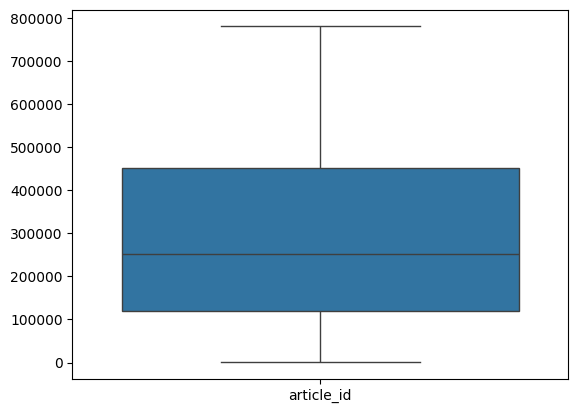

In [173]:
import seaborn as sns

sns.boxplot(data=news_data)

In [174]:
domains_location_data.isnull().all()

SourceCommonName    False
location            False
Country             False
dtype: bool

In [175]:
domains_location_data.empty

False

<Axes: >

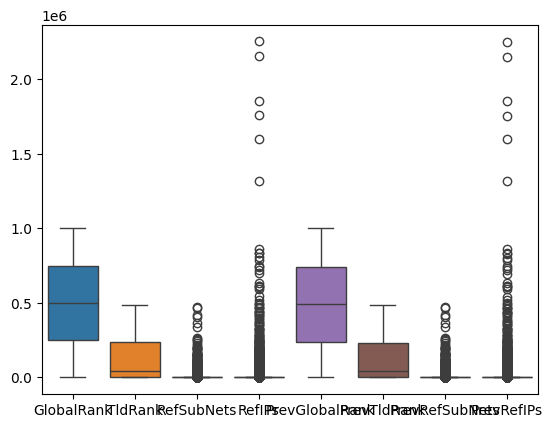

In [177]:

sns.boxplot(data=traffic_data)

Clean the data:
* Remove duplicate rows:

## **Exploratory Data Analysis (EDA)**

In [163]:
news_data.columns

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'full_content'],
      dtype='object')

In [164]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58432 entries, 0 to 105374
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_id    58432 non-null  int64 
 1   source_id     58432 non-null  object
 2   source_name   58432 non-null  object
 3   author        58432 non-null  object
 4   title         58432 non-null  object
 5   description   58432 non-null  object
 6   url           58432 non-null  object
 7   url_to_image  58432 non-null  object
 8   published_at  58432 non-null  object
 9   content       58432 non-null  object
 10  category      58432 non-null  object
 11  full_content  58432 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.8+ MB


In [178]:
news_data.describe()

,article_id
count,58432.000000
mean,298799.272625
std,216012.355400
min,418.000000
25%,119318.750000
50%,251549.000000
75%,451517.250000
max,781308.000000


In [179]:
top_N = 10

In [ ]:
"""Get the top N countries with the highest number of articles written about them"""
!pip install spacy-transformers

# Load the SpaCy model
nlp = spacy.load("en_core_web_trf")

# nlp.max_length = 3500000  # Increase the maximum length limit

# Concantenating all the news articles into a single string
all_articles = " ".join(news_data['content'].dropna())

# Using SpaCy to process the text
doc = nlp(all_articles)

# Extracting the countries mentioned in the articles
countries = [ent.text for ent in doc.ents if ent.label_ == "GPE"]

# Counting the number of times each country is mentioned
country_counts = Counter(countries)

print(country_counts.most_common(top_N))

In [180]:
def get_websites_reporting_on_regions(news_data, regions):
    """Get the websites that reported about specific regions"""

    # Load the SpaCy model
    nlp = spacy.load("en_core_web_sm")

    # Initialize a dictionary to store the results
    region_counts = {region: Counter() for region in regions}

    # Process each article
    for _, row in news_data.iterrows():
        doc = nlp(row['content'])

        # Extract country names
        countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']

        # Check if the country belongs to one of the regions
        for country in countries:
            for region, region_countries in regions.items():
                if country in region_countries:
                    region_counts[region][row['source_name']] += 1

    return region_counts

In [181]:
# Define the regions

AFRICA = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']
EU = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
MIDDLE_EAST = ['Bahrain', 'Cyprus', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'Turkey', 'United Arab Emirates', 'Yemen']

regions = {
    'Africa': AFRICA,
    'EU': EU,
    'Middle East': MIDDLE_EAST,
    'US': ['United States'],
    'China': ['China'],
    'Russia': ['Russia'],
    'Ukraine': ['Ukraine']
}

In [182]:
# Get the websites that reported about the specified regions
region_counts = get_websites_reporting_on_regions(news_data, regions)

# Print the results
for region, counts in region_counts.items():
    print(f"Websites that reported about {region}:")
    print(counts.most_common(10))
    print()

KeyboardInterrupt: 

#  top 10 and bottom 10 websites by mean sentiment

In [184]:
def calculate_sentiment(text):
    """Calculate sentiment score using TextBlob"""
    return TextBlob(text).sentiment.polarity

In [185]:
def sentiment_statistics(news_data):
    """Calculate sentiment statistics for each website"""
    # Calculate sentiment scores
    news_data['sentiment'] = news_data['content'].apply(calculate_sentiment)

    # Create columns for positive, neutral, and negative sentiment counts
    news_data['positive_sentiment'] = (news_data['sentiment'] > 0).astype(int)
    news_data['neutral_sentiment'] = (news_data['sentiment'] == 0).astype(int)
    news_data['negative_sentiment'] = (news_data['sentiment'] < 0).astype(int)

    # Group by 'source_name' and calculate mean, median, variance, and sentiment counts
    grouped = news_data.groupby('source_name')
    mean_sentiment = grouped['sentiment'].mean()
    median_sentiment = grouped['sentiment'].median()
    variance_sentiment = grouped['sentiment'].var()
    positive_sentiment = grouped['positive_sentiment'].sum()
    neutral_sentiment = grouped['neutral_sentiment'].sum()
    negative_sentiment = grouped['negative_sentiment'].sum()

    # Return the results as a DataFrame
    return pd.DataFrame({
        'mean_sentiment': mean_sentiment,
        'median_sentiment': median_sentiment,
        'variance_sentiment': variance_sentiment,
        'positive_sentiment': positive_sentiment,
        'neutral_sentiment': neutral_sentiment,
        'negative_sentiment': negative_sentiment
    })

In [188]:
news_data.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content,sentiment,positive_sentiment,neutral_sentiment,negative_sentiment
0,89541,international-business-times,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...,0.000000,0,1,0
3,89545,the-indian-express,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...,0.000000,0,1,0
6,89551,al-jazeera-english,Al Jazeera English,Kaushik Raj,Pro-Israel rallies allowed in India but Palest...,"India, the first non-Arab country to recognise...",https://www.aljazeera.com/news/2023/10/25/pro-...,https://www.aljazeera.com/wp-content/uploads/2...,2023-10-25 09:58:17.000000,"New Delhi, India Israels relentless bombing of...",Nepal,"India, the first non-Arab country to recognise...",-0.165909,0,0,1
7,89555,the-indian-express,The Indian Express,New York Times,No nation in the world is buying more planes t...,India's largest airlines have ordered nearly 1...,https://indianexpress.com/article/business/avi...,https://images.indianexpress.com/2023/11/igiai...,2023-11-02 05:48:58.000000,No nation in the world is buying as many airpl...,Nepal,Written by Alex Travelli and Hari Kumar No nat...,0.300000,1,0,0
12,89563,the-times-of-india,The Times of India,Durgesh Nandan Jha,PM Hasina’s war on terror gets daughter India’...,India News: NEW DELHI: India preferred Banglad...,https://timesofindia.indiatimes.com/india/pm-h...,"https://static.toiimg.com/thumb/msid-47529300,...",2023-11-02 01:12:47.000000,Ranked! Worlds most loved landmarks; Taj Mahal...,Nepal,NEW DELHI: India preferred Bangladesh over Nep...,0.400000,1,0,0


In [186]:
# Calculate sentiment statistics
sentiment_stats = sentiment_statistics(news_data)

# Sort the DataFrame by mean sentiment and get the top 10 and bottom 10 websites
top_10_websites = sentiment_stats.sort_values(by='mean_sentiment', ascending=False).head(10)
bottom_10_websites = sentiment_stats.sort_values(by='mean_sentiment', ascending=True).head(10)

# Print the top 10 and bottom 10 websites
print("Top 10 websites by mean sentiment:")
print(top_10_websites)
print("\nBottom 10 websites by mean sentiment:")
print(bottom_10_websites)

Top 10 websites by mean sentiment:
                    mean_sentiment  median_sentiment  variance_sentiment  \
source_name                                                                
ETF Daily News            0.192516          0.200000            0.011449   
Digital Trends            0.181484          0.166667            0.045147   
Android Central           0.169485          0.133333            0.044537   
Wired                     0.114004          0.100000            0.056520   
The Verge                 0.110896          0.068182            0.048206   
The Times of India        0.099240          0.025000            0.053145   
Forbes                    0.099031          0.056061            0.048592   
Deadline                  0.098598          0.050000            0.035788   
Gizmodo.com               0.096349          0.064782            0.034850   
Euronews                  0.094749          0.045455            0.043854   

                    positive_sentiment  neutral_sent

### Median sentiment, top and bottom 10

In [187]:
# Sort the DataFrame by median sentiment and get the top 10 and bottom 10 websites
top_10_websites_median = sentiment_stats.sort_values(by='median_sentiment', ascending=False).head(10)
bottom_10_websites_median = sentiment_stats.sort_values(by='median_sentiment', ascending=True).head(10)

# Print the top 10 and bottom 10 websites by median sentiment
print("\nTop 10 websites by median sentiment:")
print(top_10_websites_median)
print("\nBottom 10 websites by median sentiment:")
print(bottom_10_websites_median)


Top 10 websites by median sentiment:
                 mean_sentiment  median_sentiment  variance_sentiment  \
source_name                                                             
ETF Daily News         0.192516          0.200000            0.011449   
Digital Trends         0.181484          0.166667            0.045147   
Android Central        0.169485          0.133333            0.044537   
Wired                  0.114004          0.100000            0.056520   
The Verge              0.110896          0.068182            0.048206   
Boing Boing            0.094225          0.066667            0.056958   
Gizmodo.com            0.096349          0.064782            0.034850   
Forbes                 0.099031          0.056061            0.048592   
ReadWrite              0.066033          0.050000            0.038543   
Phys.Org               0.080538          0.050000            0.029850   

                 positive_sentiment  neutral_sentiment  negative_sentiment  
source_n

# Compare metadata across sites

## Compare similarity of raw message length across sites and their distribution



In [232]:
def calculate_message_length(news_data):
    """Calculate the length of raw messages for each article"""
    news_data['message_length'] = news_data['content'].apply(len)
    return news_data

In [ ]:
# Calculate message length and title word count
news_data = calculate_message_length(news_data)
news_data = calculate_title_word_count(news_data)

# Group by 'source_name' and calculate descriptive statistics for message length
message_length_stats = news_data.groupby('source_name')['message_length'].describe()

# Print the descriptive statistics
print("Message length statistics:")
print(message_length_stats)

## Compare similarity of number of words in the title across sites and their distribution

In [233]:

def calculate_title_word_count(news_data):
    """Calculate the number of words in the title for each article"""
    news_data['title_word_count'] = news_data['title'].apply(lambda x: len(str(x).split()))
    return news_data

In [234]:
# Group by 'source_name' and calculate descriptive statistics title word count
title_word_count_stats = news_data.groupby('source_name')['title_word_count'].describe()

In [235]:
# Print the descriptive statistics
print("\nTitle word count statistics:")
print(title_word_count_stats)


Title word count statistics:
                                count       mean       std  min   25%   50%  \
source_name                                                                   
ABC News                       2006.0  13.468594  2.619848  1.0  12.0  13.5   
Al Jazeera English             1588.0  10.155542  1.875552  2.0   9.0  10.0   
AllAfrica - Top Africa News      18.0  10.055556  2.071437  7.0   9.0  10.0   
Android Central                 519.0  12.256262  2.912136  4.0  10.0  12.0   
BBC News                       2039.0   9.330554  1.769495  3.0   8.0   9.0   
Boing Boing                     696.0  12.149425  4.033040  3.0   9.0  12.0   
Business Insider               1979.0  17.974735  5.189276  2.0  15.0  18.0   
CNA                             710.0  10.914085  2.653937  5.0   9.0  11.0   
CNN                             256.0  13.191406  3.707767  3.0  11.0  13.0   
Deadline                        896.0  15.530134  4.976053  6.0  12.0  15.0   
Digital Trends        

#### Manually create dictionary mapping for news websites with source names to their domains

In [228]:
# Manually create a dictionary mapping source names to their domains
source_domain_mapping = {
    'ETF Daily News': 'etfdailynews.com',
    'The Times of India': 'timesofindia.indiatimes.com',
    'GlobeNewswire': 'globenewswire.com',
    'Globalsecurity.org': 'globalsecurity.org',
    'Forbes': 'forbes.com',
    'BBC News': 'bbc.co.uk',
    'ABC News': 'abcnews.go.com',
    'Business Insider': 'businessinsider.com',
    'The Punch': 'punchng.com',
    'Al Jazeera English': 'aljazeera.com',
    'Marketscreener.com': 'marketscreener.com',
    'Phys.Org': 'phys.org',
    'International Business Times': 'ibtimes.com',
    'The Indian Express': 'indianexpress.com',
    'RT': 'rt.com',
    'NPR': 'npr.org',
    'Deadline': 'deadline.com',
    'Digital Trends': 'digitaltrends.com',
    'CNA': 'channelnewsasia.com',
    'Boing Boing': 'boingboing.net',
    'Time': 'time.com',
    'Android Central': 'androidcentral.com',
    'Gizmodo.com': 'gizmodo.com',
    'ReadWrite': 'readwrite.com',
    'Euronews': 'euronews.com',
    'Wired': 'wired.com',
    'CNN': 'cnn.com',
    'The Verge': 'theverge.com',
    'AllAfrica - Top Africa News': 'allafrica.com'
}

In [229]:
# Add a new column 'url' to the DataFrame
news_data['url'] = news_data['source_name'].map(source_domain_mapping)

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate total number of reports by each website
total_reports = news_data['source_name'].value_counts().reset_index()
total_reports.columns = ['source_name', 'total_reports']

# Step 2: Add a new column 'url' to the DataFrame
total_reports['url'] = total_reports['source_name'].map(source_domain_mapping)

# Impact of frequent news reporting and sentiment to the website’s global ranking. 2D Scatter plot graph

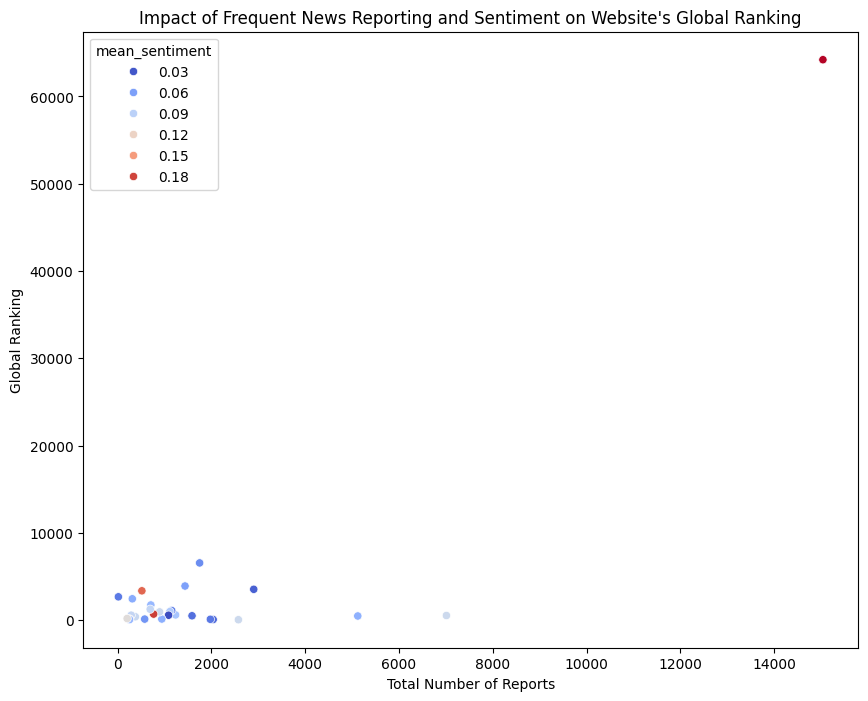

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge total_reports with traffic_data on 'url'
merged_data = pd.merge(total_reports, traffic_data, left_on='url', right_on='Domain')

# Merge merged_data with sentiment_stats on 'source_name'
final_data = pd.merge(merged_data, sentiment_stats, on='source_name')

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=final_data, x='total_reports', y='GlobalRank', hue='mean_sentiment', palette='coolwarm')
plt.title('Impact of Frequent News Reporting and Sentiment on Website\'s Global Ranking')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Ranking')
plt.show()